# Tiles

In [ ]:
%pip install geopandas

In [116]:
import json
from pathlib import Path
from urllib.request import urlretrieve
from zipfile import ZipFile

import geopandas as gpd
import matplotlib.pyplot as plt

In [125]:
tiles_dir = Path("tiles")

name = "vegnett"
layer = "veglenke"

zip_file = tiles_dir / f"{name}.zip"
fgb_file = tiles_dir / f"{name}.fgb"
gml_file = tiles_dir / "4204NVDBVegnettPluss.gml"
mbtiles_file = tiles_dir / f"{name}.mbtiles"
pmtiles_file = tiles_dir / f"{name}.pmtiles"
filters_file = tiles_dir / "filters.json"

## Last ned data

I dette eksempelet bruker vi vegnettet i Kristiansand kommune.

In [ ]:
download_url = "https://nedlasting.geonorge.no/geonorge/Samferdsel/NVDB-VegnettPluss/GML/Samferdsel_4204_Kristiansand_5973_NVDB-VegnettPluss_GML.zip"

urlretrieve(download_url, zip_file)
with ZipFile(zip_file, "r") as zip:
    zip.extract(gml_file.name, tiles_dir)

zip_file.unlink()
gpd.list_layers(gml_file)

,name,geometry_type
0,GjennomkjøringForbudtTil,Point Z
1,Fartsgrense,LineString Z
2,FunksjonellVegklasse,LineString Z
3,GjennomkjøringForbudt,Point Z
4,Gågatereguleringer,LineString Z
5,Høydebegrensning,LineString Z
6,Jernbanekryssing,Point Z
7,Landbruksvegklasse,LineString Z
8,Motorveg,LineString Z
9,Serviceveg,LineString Z


## Lagre geometri som FlatGeobuf

In [91]:
gdf = gpd.read_file(
    filename=gml_file,
    layer=layer.title(),
)

gdf["geometry"] = gdf.force_2d()

gdf = gdf.to_crs(4326)

gdf = gdf[["lokalId", "vegkategori", "geometry"]]

gdf.to_file(
    driver="FlatGeobuf",
    filename=fgb_file,
    layer=layer,
)

Vis vegnettet i Kristiansand kommune.

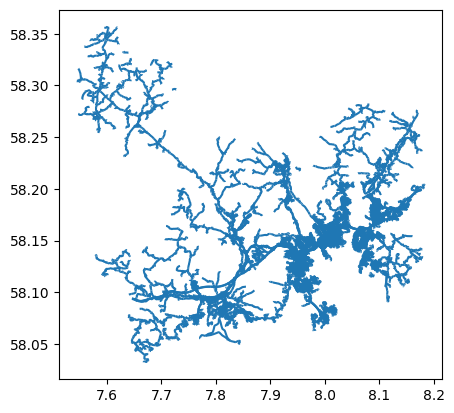

In [94]:
gdf = gpd.read_file(
    filename=fgb_file,
    layer=layer,
)

gdf.plot()

plt.show()

## Lagre tiles med OGR

GeoPandas kan via OGR produsere både MBTiles (tiles lagret i en SQLite-database [github.com/mapbox/mbtiles-spec](https://github.com/mapbox/mbtiles-spec)) og PMTiles.

In [ ]:
min_zoom = 4
max_zoom = 14

gdf = gpd.read_file(
    filename=fgb_file,
    layer=layer,
)

mbtiles_file.unlink()

gdf.to_file(
    driver="MVT",
    filename=mbtiles_file,
    layer=layer,
    MINZOOM=min_zoom,
    MAXZOOM=max_zoom,
    FORMAT="MBTILES",
)

pmtiles_file.unlink()

gdf.to_file(
    driver="PMTiles",
    filename=pmtiles_file,
    layer=layer,
    MINZOOM=min_zoom,
    MAXZOOM=max_zoom,
)

c:\Users\vidhav\Github\kartAI\skygeo\.venv\Lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: At least one tile exceeded the default maximum tile size of 500000 bytes and was encoded at lower resolution
  ogr_write(


## Tippecanoe

Tippecanoe generaliserer geometrien ut fra hvor mye som vil være synlig på de forskjellige zoom-nivåene.

Man kan også styre hvilke objekter som skal med, ved å bruke *vector tiles styles expressions*: [maplibre.org/maplibre-style-spec/expressions/](https://maplibre.org/maplibre-style-spec/expressions/). Kalles via `--feature-filter-file tiles/filters.json`. 

In [120]:
filters = {
    "veglenke": [
        "any", [
            "all", [
                ">=", "$zoom", 4
            ],[
                "==", "vegkategori", "E"
            ],
        ],[
            "all", [
                ">=", "$zoom", 8
            ],[
                "==", "vegkategori", "R"
            ],
        ],[
            "all", [
                ">=", "$zoom", 10
            ],[
                "==", "vegkategori", "F"
            ],
        ],[
            "all", [
                ">=", "$zoom", 12
            ],[
                "in", "vegkategori", "K", "P", "S"
            ],
        ],
    ],
}

with filters_file.open("w") as f:
    json.dump(filters, f, indent=4)

filters

{'veglenke': ['any',
  ['all', ['>=', '$zoom', 4], ['==', 'vegkategori', 'E']],
  ['all', ['>=', '$zoom', 8], ['==', 'vegkategori', 'R']],
  ['all', ['>=', '$zoom', 10], ['==', 'vegkategori', 'F']],
  ['all', ['>=', '$zoom', 12], ['in', 'vegkategori', 'K', 'P', 'S']]]}

In [ ]:
# Dersom tippecanoe er installert kan man kjøre denne kommandoen:
!tippecanoe --force --layer veglenke --feature-filter-file tiles/filters.json --output tiles/vegnett.pmtiles tiles/vegnett.fgb